In [1]:
!pip -q install -U "numpy<2" pandas matplotlib pyarrow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = "manipal_atmospherics_df.csv"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
numba 0.57.0 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.


/Users/sooryas/anaconda3/lib/python3.11/site-packages/pandas/core/computation/expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.4' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/sooryas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def load_weather_df(csv_path: str) -> pd.DataFrame:
    with open(csv_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    header_idx = None
    for i, line in enumerate(lines):
        if line.strip().startswith("time,"):
            header_idx = i
            break

    if header_idx is None:
        raise ValueError("Header row starting with 'time,' not found.")

    df = pd.read_csv(csv_path, skiprows=header_idx)
    df["time"] = pd.to_datetime(df["time"])
    df = df.drop_duplicates(subset="time").sort_values("time").reset_index(drop=True)

    t = df["temperature_2m_mean (°C)"]
    td = df["dew_point_2m_mean (°C)"]
    es = 6.112 * np.exp((17.67 * t) / (t + 243.5))
    e = 6.112 * np.exp((17.67 * td) / (td + 243.5))
    df["relative_humidity (%)"] = (100.0 * (e / es)).clip(0, 100)

    day = df["time"].dt.dayofyear
    df["sin_day_of_year"] = np.sin(2 * np.pi * day / 365.25)
    df["cos_day_of_year"] = np.cos(2 * np.pi * day / 365.25)

    return df


df = load_weather_df(CSV_PATH)
df.head()

,time,temperature_2m_mean (°C),precipitation_sum (mm),shortwave_radiation_sum (MJ/m²),apparent_temperature_mean (°C),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),sunshine_duration (s),wind_direction_10m_dominant (°),pressure_msl_mean (hPa),cloud_cover_mean (%),dew_point_2m_mean (°C),soil_moisture_0_to_7cm_mean (m³/m³),relative_humidity (%),sin_day_of_year,cos_day_of_year
0,2011-01-04,24.7,0.0,19.69,27.7,17.4,4.09,36798.94,325,1009.7,70,20.4,0.278,76.997277,0.068755,0.997634
1,2011-01-05,25.4,0.0,17.77,28.5,15.9,3.91,36494.80,309,1008.7,85,20.4,0.276,73.847916,0.085906,0.996303
2,2011-01-06,26.2,0.0,19.31,28.8,18.4,4.45,36924.74,319,1008.7,61,19.4,0.273,66.189954,0.103031,0.994678
3,2011-01-07,25.6,0.0,20.26,28.0,15.6,4.52,37417.72,178,1008.6,12,18.6,0.270,65.244754,0.120126,0.992759
4,2011-01-08,25.2,0.0,20.29,28.2,15.1,4.38,37473.21,313,1008.3,29,20.0,0.268,72.905760,0.137185,0.990545


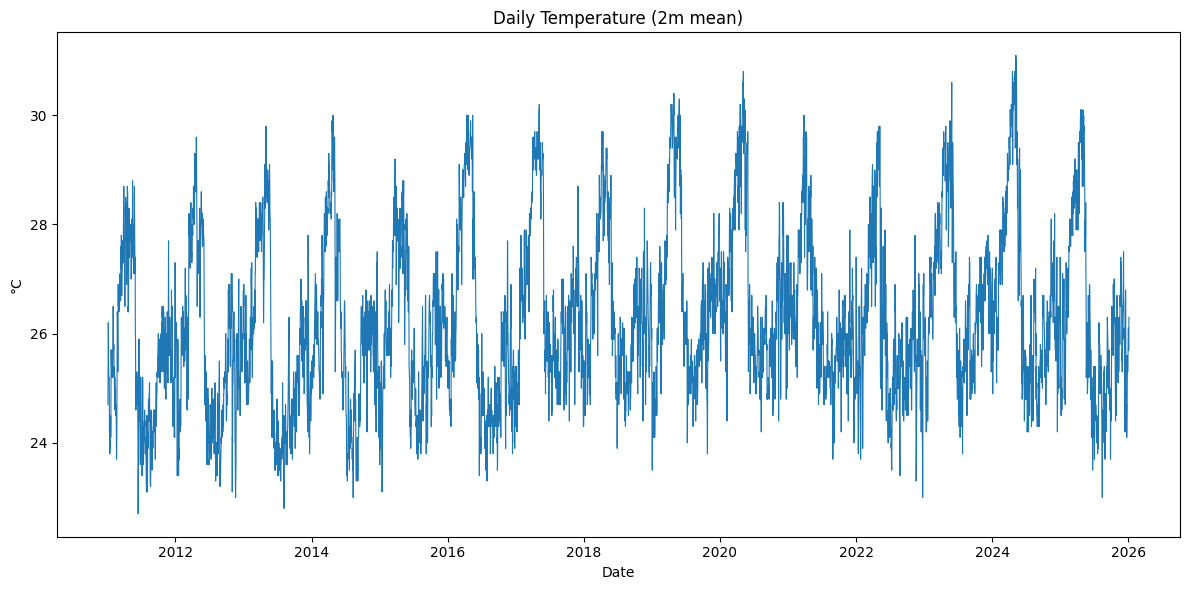

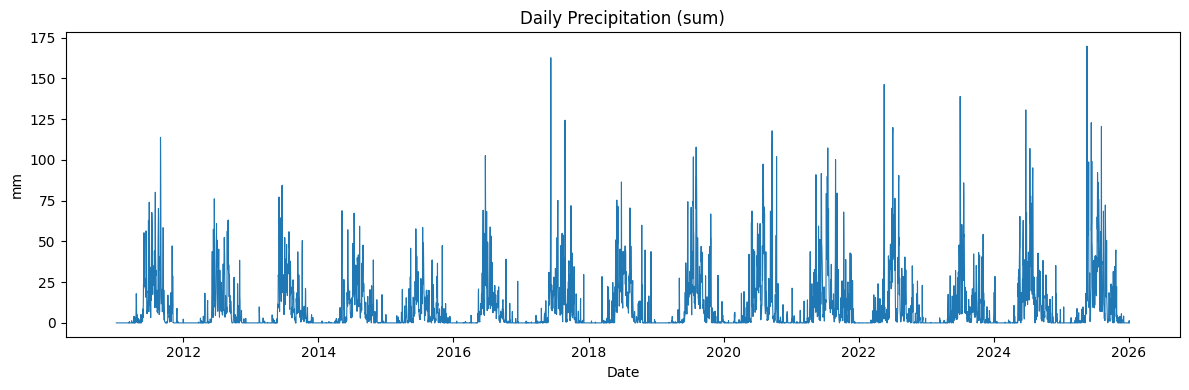

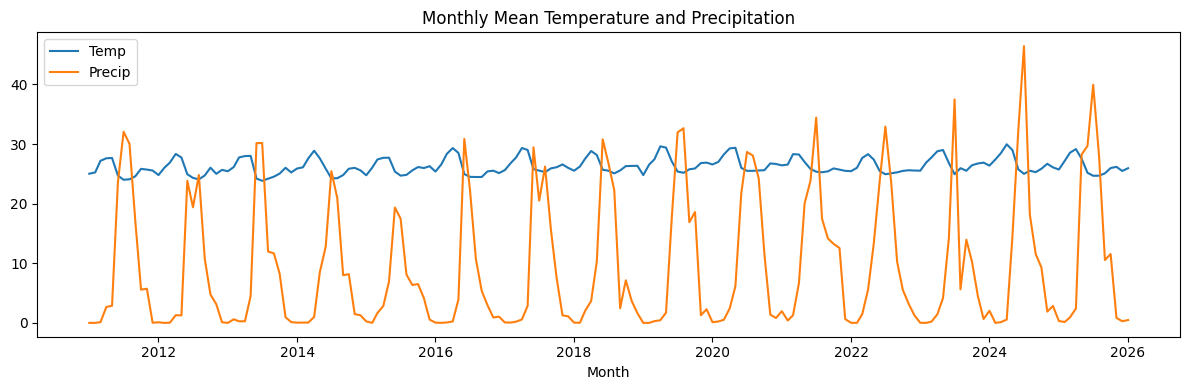

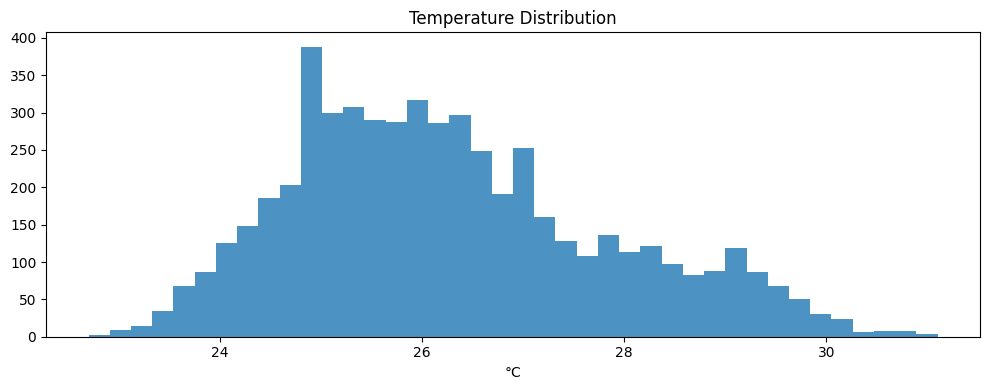

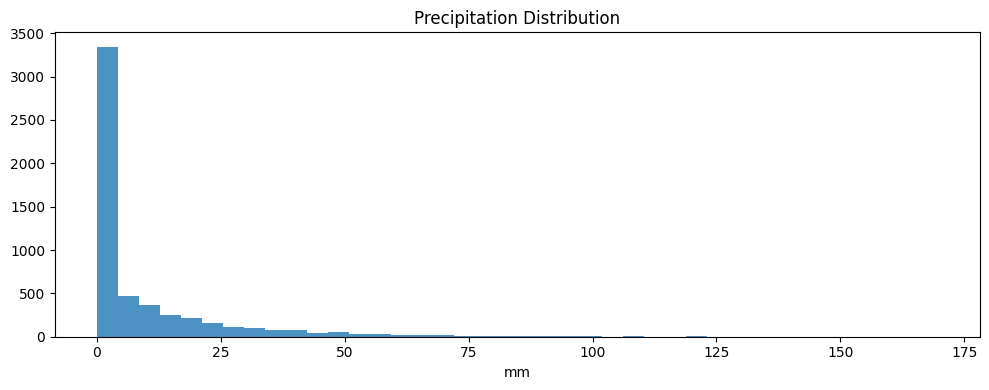

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(df["time"], df["temperature_2m_mean (°C)"], linewidth=0.8)
plt.title("Daily Temperature (2m mean)")
plt.xlabel("Date")
plt.ylabel("°C")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(df["time"], df["precipitation_sum (mm)"], linewidth=0.8)
plt.title("Daily Precipitation (sum)")
plt.xlabel("Date")
plt.ylabel("mm")
plt.tight_layout()
plt.show()

monthly = df.copy()
monthly["month"] = monthly["time"].dt.to_period("M").dt.to_timestamp()
monthly_means = monthly.groupby("month")[["temperature_2m_mean (°C)", "precipitation_sum (mm)"]].mean()

plt.figure(figsize=(12, 4))
plt.plot(monthly_means.index, monthly_means["temperature_2m_mean (°C)"], label="Temp")
plt.plot(monthly_means.index, monthly_means["precipitation_sum (mm)"], label="Precip")
plt.title("Monthly Mean Temperature and Precipitation")
plt.xlabel("Month")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(df["temperature_2m_mean (°C)"], bins=40, alpha=0.8)
plt.title("Temperature Distribution")
plt.xlabel("°C")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(df["precipitation_sum (mm)"], bins=40, alpha=0.8)
plt.title("Precipitation Distribution")
plt.xlabel("mm")
plt.tight_layout()
plt.show()